## importing libraries and custom functions

In [253]:
seed = 42

import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt.rc('figure', figsize=(10, 6))

import pickle
import IPython.display

In [254]:
"""display options"""

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option("max_colwidth")

In [255]:
"""Importing functions and style params"""
os.chdir('C:/Users/VP/Google Drive/Education/OC/working_directory/personal_modules')
%run -i useful_functions.py


# plot params
- set_style_pers

# EDA functions
 ## multiple dfs exploration
- dfs_insight
 ## univariate analysis
- plot_cont_kde
- plot_cat_countplot
# Clustering functions
- radar_ploting_clustering



<Figure size 720x432 with 0 Axes>

# Importing datasets after EDA

these datasets have been cleaned from outliers for DAYS_BIRTH, cat variables have been onehotencoded or labelencoded (card <= 2) and variables correlated at more than 0.8 were removed

In [256]:
with open("D:/Dowloads_D/Data_OC/P7/uncorr_data.txt", 'rb') as fic:
    mon_depickler = pickle.Unpickler(fic)
    loaded = mon_depickler.load()

train, test = loaded

In [257]:
dfs_dict= dict()
dfs_dict["train"] = train
dfs_dict["test"] = test

# sampling dataset for cross validation

In [258]:
from sklearn.model_selection import train_test_split

In [259]:
# sampling the train dataset to make the CV faster, stratifying as per TARGET
train_sample, val_sample = train_test_split(train, test_size=0.90, stratify=train['TARGET'], random_state=seed)

In [260]:
target_count = train_sample['TARGET'].value_counts()
target_count

0    28269
1     2482
Name: TARGET, dtype: int64

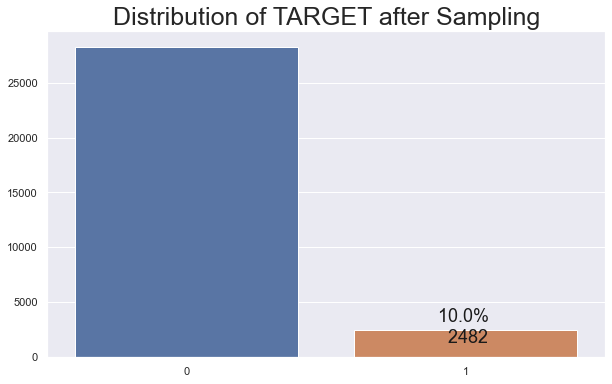

In [261]:
sns.barplot(x=target_count.index, y=target_count.values)

for p in plt.gca().patches:
    plt.gca().annotate("{:.1%} \n {}".format(round(p.get_height() / sum(target_count.values), 1)
                                             , round(p.get_height()))                             # % and count
                        , (p.get_x()+0.4, p.get_height()+2000)                                    # position
                        , ha='center', va='top', color='k', size=18)                              # kwargs
    
plt.title('Distribution of TARGET after Sampling', fontsize=25);

# Preprocessing pipeline

### Particular case, imputation of Days_Employed

During the EDA, we spotted 55474 clients with an aberrant number of days_employed, we replaced it by NaN and flagged them with a column DAYS_EMPLOYED_ANOM.
We are now imputing them with the median of the following group: NAME_EDUCATION_TYPE>OCCUPATION_TYPE>AGE_GROUP (last one to be created below)

In [262]:
# to deep dive in EDA: there are three DAYS_EMPLOYED that are NaN but that are flagged as False, we correct it below:
# train.loc[(train['DAYS_EMPLOYED'].isna() == True) & (train['DAYS_EMPLOYED_ANOM'] == False), 'DAYS_EMPLOYED_ANOM'] = True
# train.loc[(train['DAYS_EMPLOYED'].isna() == True), 'DAYS_EMPLOYED_ANOM'] == True
# check done in EDA; looks ok, probably a punctual mistake

In [263]:
# we need categorical variables not encoded to compute this median
os.chdir('D:/Dowloads_D/Data_OC/P7' )
app_test_impute = pd.read_csv('application_test.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])
app_train_impute = pd.read_csv('application_train.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])

In [264]:
# we are going to use the age group of the client for the imputation as well
#            70y     60      45      21   
age_bins = [-25550, -21900, -16425, -7665, 0]
bins_labels = ['60-70', '45-60', '21-45', '0-21']
app_train_impute['AGE_GROUP'] = pd.cut(app_train_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)
app_test_impute['AGE_GROUP'] = pd.cut(app_test_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)

In [265]:
# we build aour table of median per group using the train data
days_employed_medians = app_train_impute[['NAME_EDUCATION_TYPE', 'AGE_GROUP', 'DAYS_EMPLOYED']].groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP']).median().reset_index()
days_employed_medians.dropna(how='any', inplace=True)
days_employed_medians

,NAME_EDUCATION_TYPE,AGE_GROUP,DAYS_EMPLOYED
0,Academic degree,60-70,365243.0
1,Academic degree,45-60,-1552.0
2,Academic degree,21-45,-1846.0
4,Higher education,60-70,365243.0
5,Higher education,45-60,-1762.0
6,Higher education,21-45,-1435.0
8,Incomplete higher,60-70,365243.0
9,Incomplete higher,45-60,-1588.0
10,Incomplete higher,21-45,-1109.0
12,Lower secondary,60-70,365243.0


In [266]:
# we add non encoded grouping features to the train dataset
train['NAME_EDUCATION_TYPE'] = app_train_impute['NAME_EDUCATION_TYPE']
train['AGE_GROUP'] = app_train_impute['AGE_GROUP']

test['NAME_EDUCATION_TYPE'] = app_test_impute['NAME_EDUCATION_TYPE']
test['AGE_GROUP'] = app_test_impute['AGE_GROUP']

In [267]:
# alternative with custom heavy function that has the advatantage of preveting data leakage without creating a transformer 
mask_train = (train['DAYS_EMPLOYED_ANOM'] == True)
mask_test = (test['DAYS_EMPLOYED_ANOM'] == True)

def get_median(NAME_EDUCATION_TYPE, AGE_GROUP, days_employed_medians):
    
    days_employed_medians = days_employed_medians.loc[(days_employed_medians['NAME_EDUCATION_TYPE'] == NAME_EDUCATION_TYPE) 
                                                      # & (days_employed_medians['OCCUPATION_TYPE'] == OCCUPATION_TYPE) 
                                                      & (days_employed_medians['AGE_GROUP'] == AGE_GROUP),:]
    
    # print(days_employed_medians['DAYS_EMPLOYED'])
    return int(days_employed_medians['DAYS_EMPLOYED'])

In [268]:
train.loc[mask_train,'DAYS_EMPLOYED'] = train.loc[mask_train,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)
test.loc[mask_test,'DAYS_EMPLOYED'] = test.loc[mask_test,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)

In [269]:
# imputation using pandas (faster)
# fill_median = lambda g: g.fillna(g.median())
# train.loc[train['DAYS_EMPLOYED_ANOM'] == True,'DAYS_EMPLOYED'] = train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'])['DAYS_EMPLOYED'].apply(fill_median)

In [270]:
# imputation using pandas (faster) + use of general median in case of median equal to NaN for the group
"""
def median(s):
    m = s.median()
    if np.isnan(m):
        m = train['DAYS_EMPLOYED'].median()
    return m
train['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],
                                         dropna=False
                                        )
                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))
                          )
"""

"\ndef median(s):\n    m = s.median()\n    if np.isnan(m):\n        m = train['DAYS_EMPLOYED'].median()\n    return m\ntrain['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],\n                                         dropna=False\n                                        )\n                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))\n                          )\n"

In [271]:
# droping cat columns used for imputation
train.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# train.drop(['1'], axis=1, inplace=True)

test.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# test.drop(['1'], axis=1, inplace=True)

## imputation transform

We are building different imputers to find the best one. Note that categorical variables are now numeric thanks to encoding, so no need to applied a separa

In [272]:
from sklearn.impute import SimpleImputer

In [273]:
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
zero_imputer = SimpleImputer(strategy='constant')

### Custom imputer

We are going to create a custom transformer that will apply two distinct treatments, either 0 for for selected variables or the the median by  for all the other variables

In [274]:
train[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)

COMMONAREA_AVG                              214865
NONLIVINGAPARTMENTS_AVG                     213514
FLOORSMIN_AVG                               208642
YEARS_BUILD_AVG                             204488
OWN_CAR_AGE                                 202929
LANDAREA_AVG                                182590
BASEMENTAREA_AVG                            179943
NONLIVINGAREA_AVG                           169682
APARTMENTS_AVG                              156061
ENTRANCES_AVG                               154828
FLOORSMAX_AVG                               153020
YEARS_BEGINEXPLUATATION_AVG                 150007
AMT_REQ_CREDIT_BUREAU_HOUR                   41519
AMT_REQ_CREDIT_BUREAU_DAY                    41519
AMT_REQ_CREDIT_BUREAU_WEEK                   41519
AMT_REQ_CREDIT_BUREAU_MON                    41519
AMT_REQ_CREDIT_BUREAU_QRT                    41519
AMT_REQ_CREDIT_BUREAU_YEAR                   41519
DEF_30_CNT_SOCIAL_CIRCLE                      1021
OBS_30_CNT_SOCIAL_CIRCLE       

EXT_SOURCE_2_x has 0.2% of NaN, so we can impute it with median despite its correlation to the target without running the risk of biasing the dataset

In [275]:
# variables where NaN will be replaced by 0
zero_imputed_cols = [
       *list(train[[col for col in train.columns if 'bureau' in col]].isna().mean().sort_values(ascending=False).index) # all variables to the bureau datasets, NaN are all the clients of app train that had no history in the bueau datasets, so 0 is a relevant choice
        , 'COMMONAREA_AVG' # if the person is not living in a common area, 0 would be logical
        , 'YEARS_BUILD_AVG'
        , 'OWN_CAR_AGE'   # NaN probably means client does not own a car
        , 'YEARS_BEGINEXPLUATATION_AVG'
        , 'AMT_REQ_CREDIT_BUREAU_HOUR'  # number of enquiries made about a client to credit bureau, NaN means probably no inquiries were made
        , 'AMT_REQ_CREDIT_BUREAU_DAY'
        , 'AMT_REQ_CREDIT_BUREAU_WEEK'
        , 'AMT_REQ_CREDIT_BUREAU_MON'
        , 'AMT_REQ_CREDIT_BUREAU_QRT'
        , 'AMT_REQ_CREDIT_BUREAU_YEAR'
        , 'DEF_30_CNT_SOCIAL_CIRCLE'   # NaN probably means no observations
        , 'OBS_30_CNT_SOCIAL_CIRCLE'
    
]

# variables where NaN will be replaced by median
non_zero_imputed_cols = [col for col in train.columns if col not in zero_imputed_cols]

In [276]:
from sklearn.compose import ColumnTransformer
cust_imputer = ColumnTransformer([
      ("zero_imputer", SimpleImputer(strategy='constant'), zero_imputed_cols)
    , ("median", SimpleImputer(strategy='median'), non_zero_imputed_cols)
], remainder='passthrough')

In [277]:
# test to check that custom imputer works
train_array = cust_imputer.fit_transform(train)

In [278]:
train = pd.DataFrame(train_array, index = train.index, columns=train.columns)

In [279]:
train[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)

SK_ID_CURR                                  0
ORGANIZATION_TYPE_Housing                   0
ORGANIZATION_TYPE_Business Entity Type 1    0
ORGANIZATION_TYPE_Business Entity Type 2    0
ORGANIZATION_TYPE_Business Entity Type 3    0
ORGANIZATION_TYPE_Cleaning                  0
ORGANIZATION_TYPE_Construction              0
ORGANIZATION_TYPE_Culture                   0
ORGANIZATION_TYPE_Electricity               0
ORGANIZATION_TYPE_Emergency                 0
ORGANIZATION_TYPE_Government                0
ORGANIZATION_TYPE_Hotel                     0
ORGANIZATION_TYPE_Industry: type 1          0
NAME_CONTRACT_TYPE                          0
ORGANIZATION_TYPE_Industry: type 10         0
ORGANIZATION_TYPE_Industry: type 11         0
ORGANIZATION_TYPE_Industry: type 12         0
ORGANIZATION_TYPE_Industry: type 13         0
ORGANIZATION_TYPE_Industry: type 2          0
ORGANIZATION_TYPE_Industry: type 3          0
ORGANIZATION_TYPE_Industry: type 4          0
ORGANIZATION_TYPE_Industry: type 5

## feature scaling transform

In [280]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

MinMaxScaler = MinMaxScaler()
RobustScaler = RobustScaler()

## RUS and SMOTE

In [281]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# parameters to adapt
over = SMOTE(sampling_strategy=0.4, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)

## Feature selection

In [282]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest

rfe = RFE(estimator=DecisionTreeClassifier(random_state=seed), n_features_to_select=50)
SKB = SelectKBest(k=50)

# GridSearchCV per model

We are going to to a grid search for steps and hyperparamaters for to models successively: RFClassifier and LGBM

In [283]:
from sklearn.model_selection import StratifiedKFold

## SKFold and spliting X and y

In [284]:
# stratified kfold used for the two CVs
Skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [311]:
# splitting features and Target 
X, y = train_sample.iloc[:,2:-1], train_sample.iloc[:,-1]

### test smote + RUS

In [286]:
from imblearn.pipeline import Pipeline as im_pipeline

In [287]:
class cust_im_pipeline(im_pipeline):
    def just_transforms(self, X):
        """Applies all transforms to the data, without applying last 
           estimator.

        Parameters
        ----------
        X : iterable
            Data to predict on. Must fulfill input requirements of first step of
            the pipeline.
        """
        Xt = X
        for name, transform in self.steps[:-1]:
            try:
                Xt = transform.transform(Xt)
            except:
                Xt = transform.transform(Xt)
        return Xt

In [288]:
pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
])

In [289]:
Xr= pipe.fit_transform(X, y)

In [290]:
Xo, yo = over.fit_sample(Xr, y)

In [291]:
Xo.shape

(39576, 313)

In [292]:
yo.value_counts()

0    28269
1    11307
Name: TARGET, dtype: int64

In [293]:
Xu, yu = under.fit_sample(Xr, y)

In [294]:
yu.value_counts()

0    4964
1    2482
Name: TARGET, dtype: int64

## RFClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=seed)

### building imbl pipeline and grid

In [44]:
pipe_rfc = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('RFC', RandomForestClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [45]:
imputers=[
       #median_imputer 
     mean_imputer # best
    #, zero_imputer # retunrs NaN
    #, cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
     over
    #, under
]
# Feature_selectors
SKB #best

# params grid

param_grid_rfc = {  'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [10]
        , 'RFC__n_estimators': [50]
       }

In [46]:
from sklearn.model_selection import GridSearchCV

grid_rfc = GridSearchCV(pipe_rfc, param_grid_rfc, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, )

In [47]:
%%timeit
grid_rfc.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ........... (step 1 of 5) Processing imputer, total=   0.3s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.1s
[Pipeline] .............. (step 3 of 5) Processing over, total=   0.0s


C:\Users\VP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 14  41  43  49  51  76  80  81 149 197 211 220 223 230] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ........

In [48]:
grid_rfc.best_params_

{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42),
 'RFC__max_depth': 10,
 'RFC__n_estimators': 50,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(),
 'over': SMOTE(random_state=42, sampling_strategy=0.4),
 'scaler': RobustScaler()}

In [49]:
grid_rfc_results = pd.DataFrame(grid_rfc.cv_results_)

In [50]:
grid_rfc_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RFC,param_RFC__max_depth,param_RFC__n_estimators,param_feat_selec,param_imputer,param_over,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.004522,0.152328,0.074592,0.014096,"RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)",10,50,SelectKBest(k=50),SimpleImputer(),"SMOTE(random_state=42, sampling_strategy=0.4)",RobustScaler(),"{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42), 'RFC__max_depth': 10, 'RFC__n_estimators': 50, 'feat_selec': SelectKBest(k=50), 'imputer': SimpleImputer(), 'over': SMOTE(random_state=42, sampling_strategy=0.4), 'scaler': RobustScaler()}",0.699578,0.67558,0.62461,0.66789,0.704044,0.67434,0.028409,1


#### Imputers grid results

In [51]:
grid_rfc_results['param_imputer'] = grid_rfc_results['param_imputer'].astype('str')

In [52]:
grid_rfc_results[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_imputer,,
SimpleImputer(),0.67434,0.028409


Mean imputation (0.695) is slightly better than median (0.688) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [53]:
grid_rfc_results['param_scaler'] = grid_rfc_results['param_scaler'].astype('str')

In [54]:
grid_rfc_results[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_scaler,,
RobustScaler(),0.67434,0.028409


RobustScaler (0.694) is slightly better than MinMaxScaler (0.688987)

#### Feature selector grid results

In [55]:
grid_rfc_results['param_feat_selec'] = grid_rfc_results['param_feat_selec'].astype('str')

In [56]:
grid_rfc_results[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_feat_selec,,
SelectKBest(k=50),0.67434,0.028409


En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

In [57]:
max(grid_rfc.cv_results_['mean_test_score'])

0.6743404520546419

## LGBMC

In [192]:
from lightgbm import LGBMClassifier
LBMC = LGBMClassifier(objective='binary', random_state=seed)

### building imbl pipeline and grid

In [323]:
pipe_lgbm = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [296]:
imputers=[
     median_imputer # best
    #, mean_imputer 
    #, zero_imputer # retunrs NaN
    #, cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
     over
    #, under
]
# Feature_selectors
SKB #best

# LGBM parameters
boosting_type = [
    #'gbdt'
     'dart' # best
    #, 'goss'
    #, 'rf'   
]
max_depth =[
    7
    , 8
    , 10
    #, 50
    #, 100
    #, None
]
n_estimators=[
    20
    , 30
    , 40
]
num_leaves=[
    5
    , 7
    , 10
]
subsample=[
    1
    , .8
]
colsample_bytree=[
    .8
]
reg_alpha=[
    0
    ,.1
]
reg_lambda=[
    0
    , .1
]
min_split_gain=[
      0
    , .01
]
# params grid

param_grid_lgbm = {
          'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [SKB] 
        , 'LBMC': [LBMC]
        , 'LBMC__n_estimators':n_estimators
        , 'LBMC__num_leaves':num_leaves
        , 'LBMC__colsample_bytree':colsample_bytree
        , 'LBMC__subsample':subsample
        , 'LBMC__max_depth':max_depth
        , 'LBMC__reg_alpha':reg_alpha
        , 'LBMC__reg_lambda':reg_lambda
        , 'LBMC__min_split_gain':min_split_gain
       }

In [297]:
from sklearn.model_selection import GridSearchCV

grid_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, )

In [298]:
%timeit
grid_lgbm.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [74]:
max(grid_lgbm.cv_results_['mean_test_score'])

0.7118340056655664

In [150]:
grid_lgbm.best_params_

{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=10, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0, reg_lambda=0.1, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 10,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0,
 'LBMC__reg_lambda': 0.1,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}

### backup best params and scores

full param grid best params
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=10, min_split_gain=0,
                n_estimators=50, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 10,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 50,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}

best score = 0.715

second more specific grid
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score:0.7146
 the score is not better
 
 third grid: increased the size of the training set by 8%
 {'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score: 0.7118340056655664

In [ ]:
df_grid_lgbm = pd.DataFrame(grid_lgbm.cv_results_)

In [ ]:
df_grid_lgbm.head(1)

#### Imputers grid results

In [ ]:
df_grid_lgbm['param_imputer'] = df_grid_lgbm['param_imputer'].astype('str')

In [ ]:
df_grid_lgbm[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

median imputation (0.680) is slightly better than mean (0.679) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [ ]:
df_grid_lgbm['param_scaler'] = df_grid_lgbm['param_scaler'].astype('str')

In [ ]:
df_grid_lgbm[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

RobustScaler (0.681) is slightly better than MinMaxScaler (0.678315)

#### Feature selector grid results

In [ ]:
df_grid_lgbm['param_feat_selec'] = df_grid_lgbm['param_feat_selec'].astype('str')

In [ ]:
df_grid_lgbm[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

# Selection of the best pipe

In [ ]:
# creating the best pipe with the optimised parameters and steps
best_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', SMOTE(random_state=42, sampling_strategy=0.4))
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1))    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

# Baseline check

In [358]:
from sklearn.dummy import DummyClassifier

In [360]:
baseline_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', SMOTE(random_state=42, sampling_strategy=0.4))
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('Baseline', DummyClassifier(strategy="most_frequent"))    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [361]:
%timeit
baseline_pipe.fit(Xval, yval)

[Pipeline] ........... (step 1 of 5) Processing imputer, total=  22.2s


C:\Users\VP\anaconda3\lib\site-packages\imblearn\pipeline.py:229: UserWarning: Persisting input arguments took 1.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............ (step 2 of 5) Processing scaler, total=   2.1s


C:\Users\VP\anaconda3\lib\site-packages\imblearn\pipeline.py:229: UserWarning: Persisting input arguments took 1.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ...... (step 3 of 5) Processing weight_strat, total=  15.3s


C:\Users\VP\anaconda3\lib\site-packages\imblearn\pipeline.py:236: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, y, fitted_transformer = fit_resample_one_cached(
C:\Users\VP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [195 218] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\VP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[Pipeline] ........ (step 4 of 5) Processing feat_selec, total=   1.9s
[Pipeline] .......... (step 5 of 5) Processing Baseline, total=   0.0s


C:\Users\VP\anaconda3\lib\site-packages\imblearn\pipeline.py:229: UserWarning: Persisting input arguments took 1.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
         steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('feat_selec', SelectKBest(k=50)),
                ('Baseline', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [133]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [362]:
yval_base_pred = baseline_pipe.predict(Xval)
yval_base_pred_proba = baseline_pipe.predict_proba(Xval)

In [363]:
accuracy_score(yval, yval_base_pred)

0.9192694030929325

In [365]:
roc_auc_score(yval, yval_base_pred_proba[:,1])

0.5

In [366]:
from sklearn.metrics import plot_roc_curve

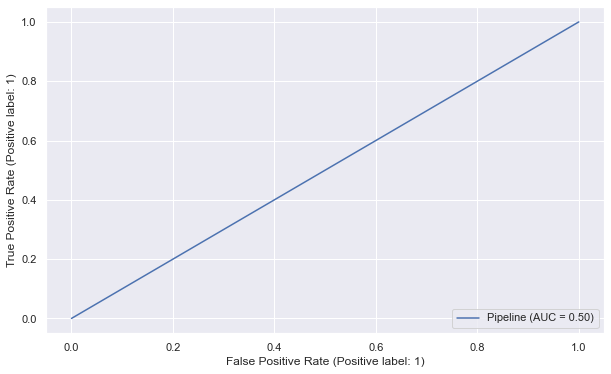

In [367]:
plot_roc_curve(baseline_pipe, Xval, yval)

Accuracy is high, but the recall of the model is low, hence an AUC of 0.5.
Best model has an AUC of 0.715

# Features importance best model

We are here analysing the features importance of the best model.

In [345]:
best_pipe.fit(X, y)

[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.4s


Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
         steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('feat_selec', SelectKBest(k=50)),
                ('LBMC',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=7,
                                min_split_gain=0, n_estimators=40,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.1, reg_lambda=0,
                                subsample=1))],
         verbose=True)

In [338]:
# getting indexes of the 50 columns selected by SelectKBest
selected_columns= best_pipe.named_steps["feat_selec"].get_support(indices=True)

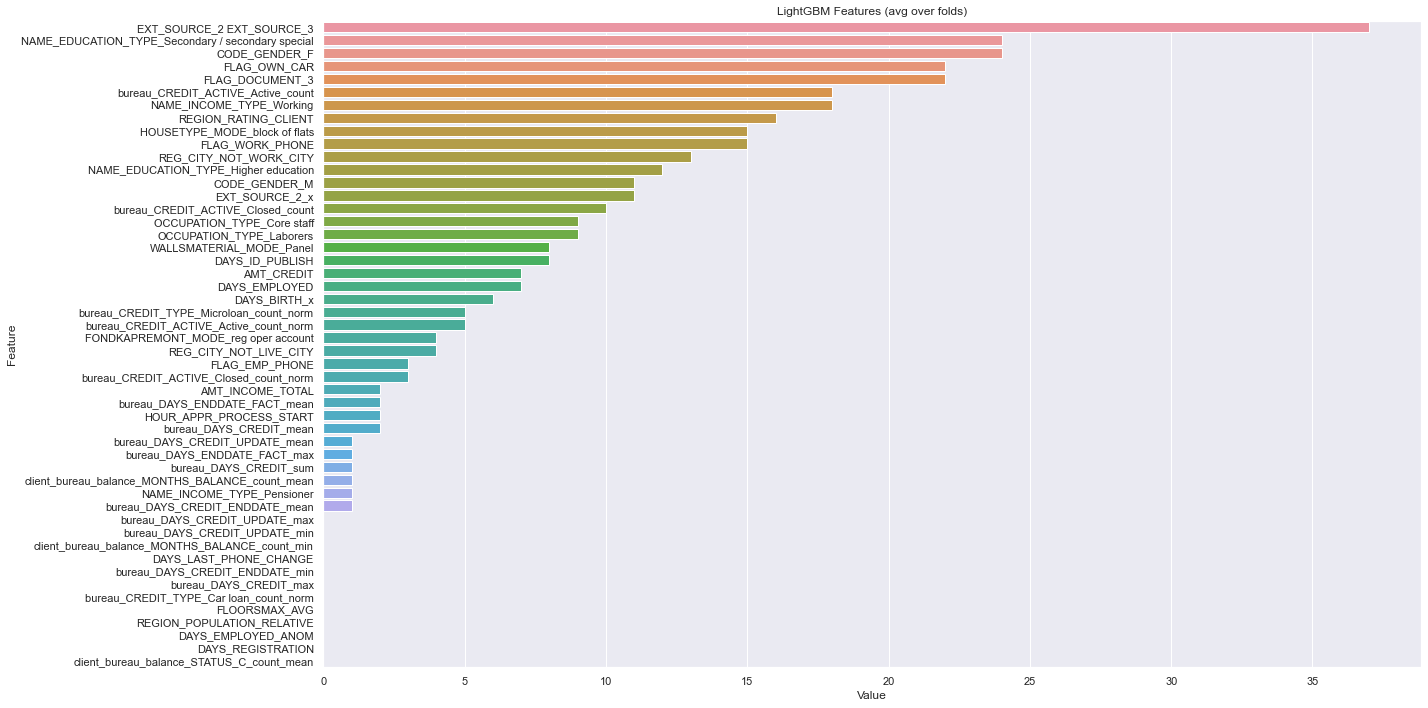

In [346]:
# collecting features importance of the selected columns in a Dataframe
feature_imp = pd.DataFrame(zip(best_pipe.named_steps["LBMC"].feature_importances_, X.iloc[:,selected_columns].columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
# and plotting it
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# confusion matrix of the best model

In [348]:
Xval, yval = val_sample.iloc[:,2:-1], val_sample.iloc[:,-1]

In [133]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [349]:
yval_pred = best_pipe.predict(Xval)
yval_pred_proba = best_pipe.predict_proba(Xval)

In [350]:
accuracy_score(yval, yval_pred)

0.9192694030929325

In [351]:
roc_auc_score(yval, yval_pred_proba[:,1])

0.7240277971238918

In [352]:
cm_lgbm = confusion_matrix(yval, yval_pred, labels=[1, 0])

In [353]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [357]:
cm_lgbm_df

Predicted        
                   def   nodef
Actual def           2   22341
       nodef         2  254415

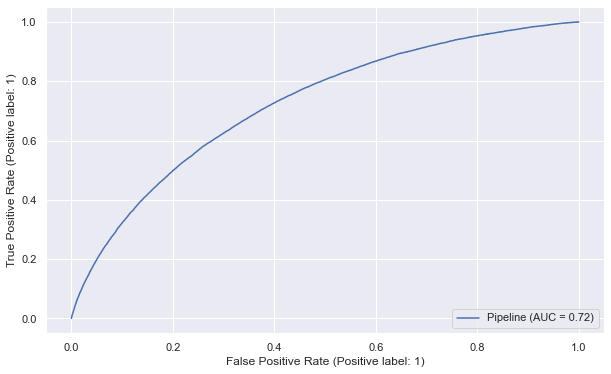

In [368]:
plot_roc_curve(best_pipe, Xval, yval)

## Optimize threshold to maximise False Negative (1-recall)

In [383]:
from sklearn.metrics import recall_score

In [370]:
def cust_predict_proba(pos_class_proba_array, thres=0.5):
    pos_class_proba_array = pd.Series(pos_class_proba_array)
    pos_class_proba_array = pos_class_proba_array.map(lambda x: 1 if x > thres else 0)
    return pos_class_proba_array.to_numpy()

In [384]:
False_Negatives_rates = [] # i need to define the custom metric here that penalizes false negatives ut do not sacrifice accuracy too much
thresholds      = [0.1 , 0.14, 0.19, 0.23, 0.28, 0.32, 0.37, 0.41, 0.46, 0.5 , 0.55, 0.59, 0.64, 0.68, 0.73, 0.77, 0.82, 0.86, 0.91, 0.95]

for thr in thresholds:
    recall = recall_score(yval, cust_predict_proba(yval_pred_proba[:,1], thres=thr))
    false_negatives_rate = 1 - recall
    False_Negatives_rates.append(false_negatives_rate)

In [385]:
False_Negatives_rates

[0.20162914559369827,
 0.3919795909233317,
 0.6005012755672918,
 0.7295349773978428,
 0.8470214384818511,
 0.9136642348834086,
 0.971087141386564,
 0.9914067045607126,
 0.9992391352996465,
 0.9999104865058408,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]